In [1]:

import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
from importlib import reload
sys.path.insert(1, './functions/')
import os
from scipy.io import loadmat

In [2]:


scale = 5
cm2inch = 0.39
ssmall_SIZE = 3*scale
SMALL_SIZE = 4*scale
MEDIUM_SIZE = 6*scale
BIGGER_SIZE = 8*scale
LINE_WIDTH = 2*2
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('lines', linewidth=LINE_WIDTH)


In [3]:
from fun_decoder import shuffle_decoder
model_name = 'mbpca_individual'
data_type ='data1'
filepath = os.path.join('./results_/results_update_order_xw/',data_type,model_name)

depth =0
filename =  model_name + '_'+data_type+'_depth'+str(depth)+'.pickle'
savefile = os.path.join(filepath,filename)
with open(savefile,'rb' ) as f:
    model = pickle.load(f)
nef =int(model.scores['nef'])
X = model.X


data = loadmat('./data/piezo_data1.mat')
spk_on = data['all_spk_scan']
spk_off = data['all_spk_scan_down']
speed = data['all_speed_scan']
move = data['all_move_scan']
from utility import lowpass_filter
speed_filter = lowpass_filter(speed, cutoff=0.1, fs=3.86, order=2)
move_filter = lowpass_filter(move, cutoff=0.1, fs=3.86, order=2)

In [4]:
def partial_decoding_del1ef(X,nef,spk_on,i = 0, tw = 6, history = 1):

    X_d = X[0:nef,:]
    X_del = np.delete(X_d,(i), axis = 0)

    result_del = shuffle_decoder(X_del, cat ='LR', spk = spk_on, 
                    tw = tw, history = history)
    score_del = result_del['score_fit']
    p_del = result_del['p']
    return score_del,p_del

def full_decoding(X,nef,spk_on, tw = 6, history = 1):
    X_d = X[0:nef,:]
    result = shuffle_decoder(X_d, cat ='LR', spk = spk_on, 
                        tw = tw, history = history)
    score = result['score_fit']
    p = result['p']
    return score, p

In [5]:
filepath = os.path.join('./results_/results_update_order_xw/',data_type,model_name)
scores_del = np.zeros((8,50))
ps_del = np.zeros((8,50))
scores = np.zeros((8))
ps = np.zeros((8))
scores_improve= np.zeros((8,50))

tw = 6
history = 1
for depth in range(8):
    filename =  model_name + '_'+data_type+'_depth'+str(depth)+'.pickle'
    savefile = os.path.join(filepath,filename)
    with open(savefile,'rb' ) as f:
        model = pickle.load(f)
    nef =int(model.scores['nef'])
    X = model.X
    # print('Depth:', depth, 'nef:', nef)

    scores[depth],ps[depth] = full_decoding(X,nef,spk_on, tw = tw, history = history)
     
    for i in range(nef):
        scores_del[depth, i],ps_del[depth, i] = partial_decoding_del1ef(X,nef,spk_on,i = i, tw =tw, history = history)
        

        scores_improve[depth,i] = (scores_del[depth, i]-scores[depth])/scores[depth]


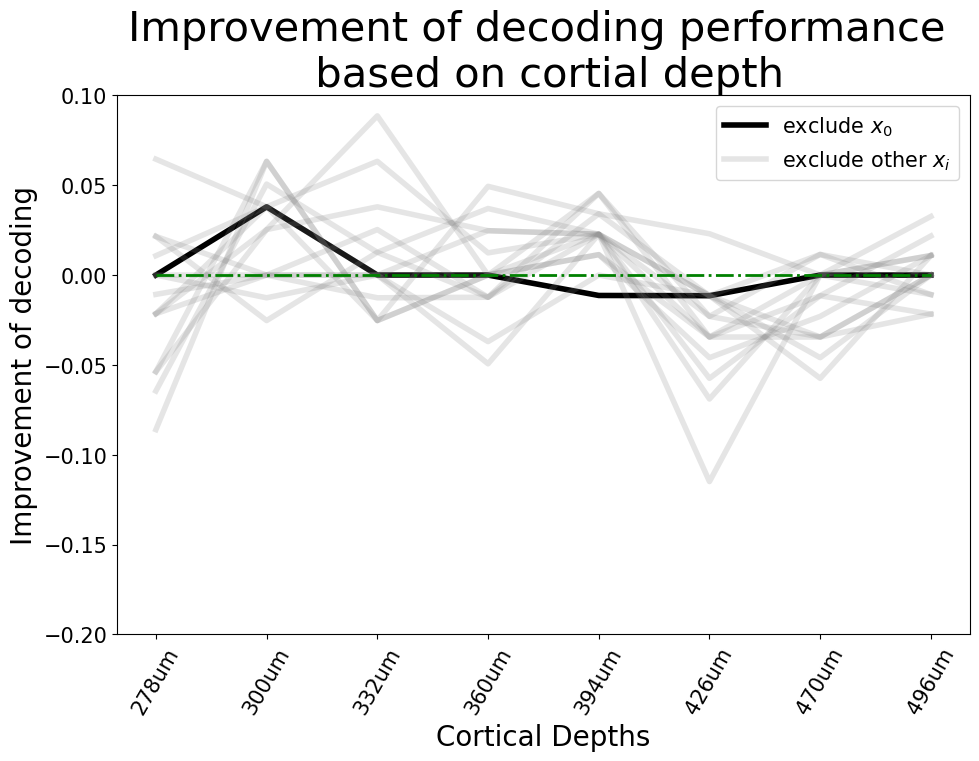

In [109]:

fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
ax.plot(scores_improve[:,0], 'k', label=r'exclude $x_0$')

ax.set_xlabel('Cortical Depths')
ax.set_ylabel('Improvement of decoding')

ax.plot(scores_improve[:,1], alpha = 0.2,label=r'exclude other $x_i$', color ='gray'); 

for i in np.arange(2, 15): 
    ax.plot(scores_improve[:,i], alpha = 0.2, color ='gray'); 

ax.hlines(y = 0, xmin = 0, xmax = 7,linestyles= '-.', color = 'g',linewidth = 2)
depths = np.array([278,300,332,360,394,426,470,496])
depths_labels = []
for i in range(len(depths)):
    depthi = depths[i]
    depths_labels.append(str(depths[i])+'um')
ax.set_xticks(np.arange(0, len(depths)))
ax.set_xticklabels(depths_labels, rotation = 60)
ax.set_title('Improvement of decoding performance \n based on cortial depth')
ax.set_ylim([-0.2,0.1])

plt.legend()

figfile ='figs/encoder/improve_decoding_depths.pdf'
plt.savefig(figfile,bbox_inches='tight')
plt.show()

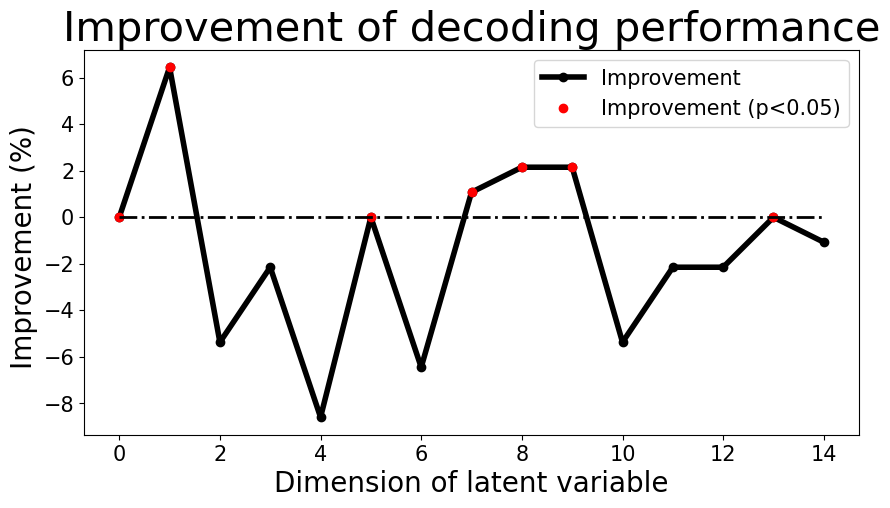

In [106]:
# plot depth 0 
depth = 0
nef = 15
score_improve_depthi = scores_del[depth, :nef]/scores[depth]-1
ps_del_depthi = ps_del[depth,:nef]


idx = np.where(ps_del_depthi<0.05)[0]
idx1 = np.where(score_improve_depthi>=0)[0]
idx_  = list(set(idx) & set(idx1))

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.plot(score_improve_depthi*100,'ko-',label ='Improvement')
ax.plot(idx_,score_improve_depthi[idx_]*100,'ro', label ='Improvement (p<0.05)')
ax.hlines(y = 0, xmin = 0, xmax = 14,linestyles= '-.', color = 'k',linewidth = 2)
ax.set_xlabel('Dimension of latent variable')
ax.set_ylabel('Improvement (%) ')
ax.set_title('Improvement of decoding performance')
plt.legend()


figfile ='figs/encoder/improve_decoding_depth0.pdf'
plt.savefig(figfile,bbox_inches='tight')
plt.show()


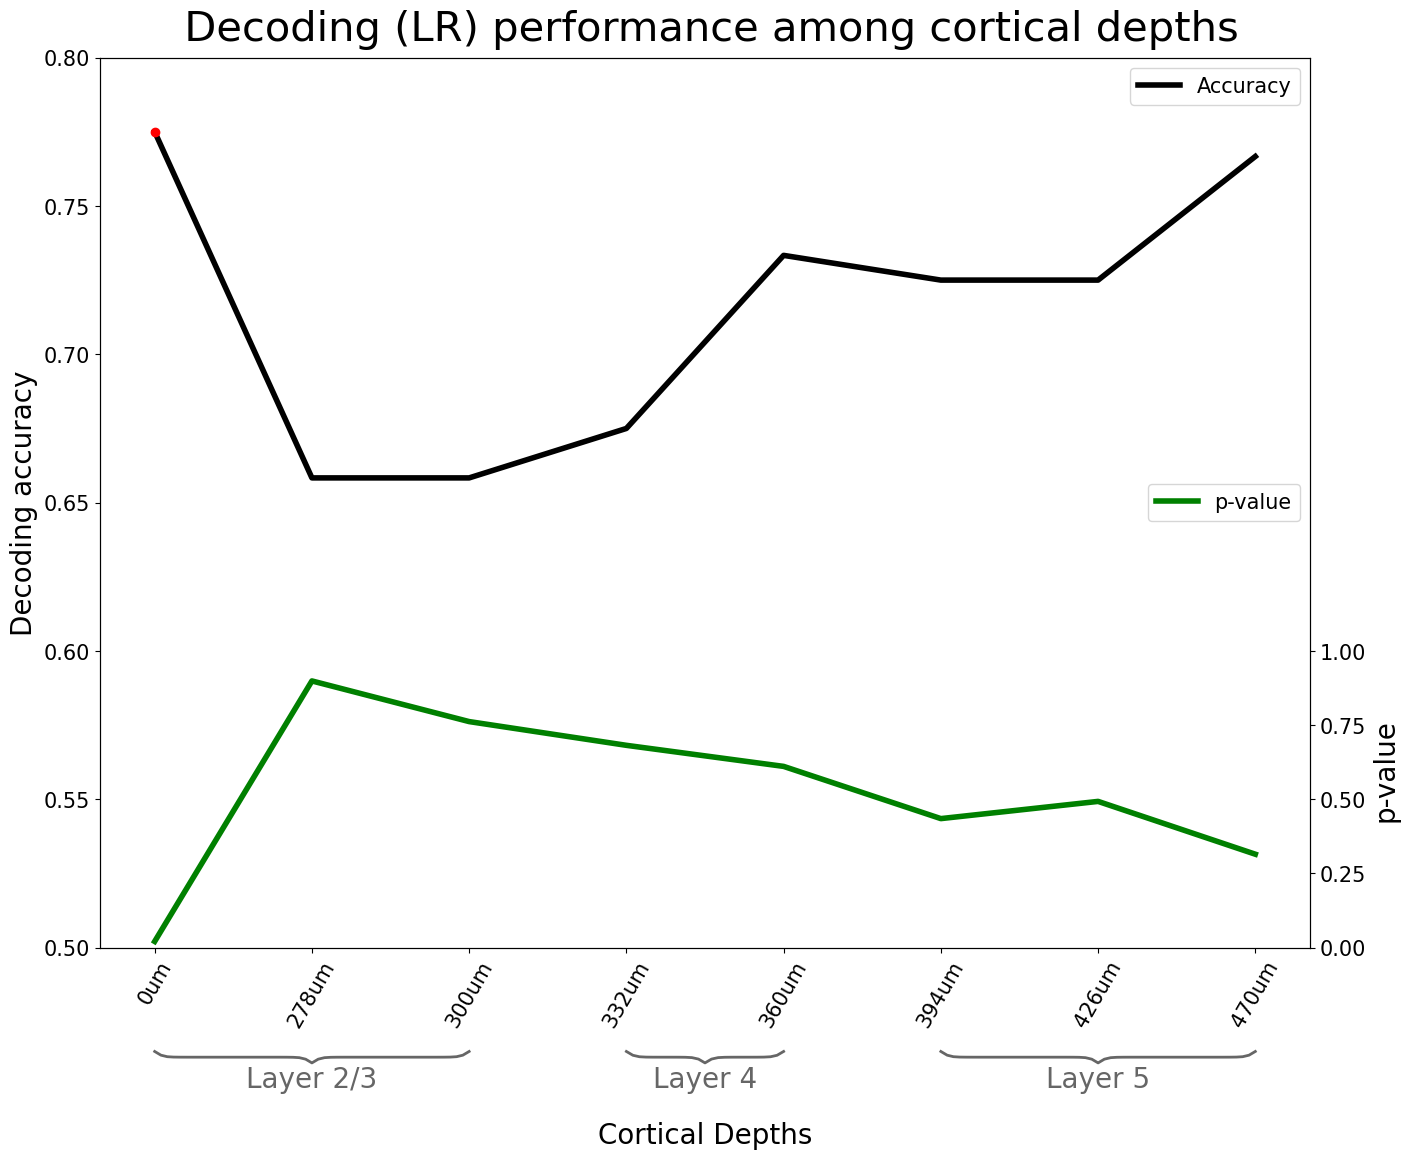

In [16]:
# decoding accuracy depth-wise 
from fun_plots import draw_brace


figsize_cm = (9, 7)
figsize_inch = (14.5, 12)
figsize = (figsize_inch[0],figsize_inch[1])

fig, ax = plt.subplots(figsize = figsize)
idx = np.where(ps<0.05)[0]
idx1 = np.where(scores>=0)[0]
idx_  = list(set(idx) & set(idx1))

ax.plot(scores,'k',label ='Accuracy')
ax.plot(idx_,scores[idx_],'ro')
# ax.set_xlabel('Cortical Depths')
ax.set_ylabel('Decoding accuracy')
depths = np.array([0,278,300,332,360,394,426,470,496])
depths_labels = []
for i in range(len(depths)):
    depthi = depths[i]
    depths_labels.append(str(depths[i])+'um')

ax.set_xticks(np.arange(0, len(depths)))

ax.set_xticklabels(depths_labels, rotation = 60)
ax.set_ylim([0.5,0.8])

plt.legend(loc = 'upper right')

xticks = ax.get_xticks()
xtick_rel_position = np.linspace(0.13, 0.81, len(xticks)) # <- these are just guessed

alpha = 0.6
brace_y = -0.5
textpos = -0.01
yscale = 0.8

ax1 = ax.twinx()
ax1.plot(ps,'g',label ='p-value')
draw_brace(ax1, (0,2), brace_y, 'Layer 2/3', alpha = alpha, textpos = textpos,yscale = yscale)
draw_brace(ax1, (3,4), brace_y, 'Layer 4',alpha = alpha, textpos = textpos,yscale = yscale)
draw_brace(ax1, (5,7), brace_y, 'Layer 5',alpha = alpha, textpos = textpos,yscale = yscale)
ax.set_xlabel('Cortical Depths',labelpad=65)

ax1.set_ylabel('p-value', y = 0.2)

ax1.set_ylim([0,3])
ax1.set_yticks(np.arange(0,1.1,0.25))
plt.legend(loc = 'right')


ax.set_title(' Decoding (LR) performance among cortical depths', y = 1.01)
plt.tight_layout()
plt.show()